# Weeks 5-6 Exercises
# Rahul Rajeev

**1. Data Wrangling with Python: Activity 7, page 207**

Link: https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)

In [2]:
# libraries
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

**1. Use inspect element to analyze the structure**

I found that the structure needed is under the table class, which is split into thead and tbody, thead representing the header
and tbody representing each row.

In [3]:
#2. read the website using bs4
# request url
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)').text
# parse using Beautiful soup
soup = BeautifulSoup(website_url,'html.parser')

In [4]:
# 3. find the table structure you will use (how many table structures are there?)

# find all table structures
all_tables = soup.find_all("table")

# counting the number of tables
print("Total number of tables are {} ".format(len(all_tables)))

Total number of tables are 7 


In [5]:
# 4. Find the right table using bs4
# searching for a specific table with classes of wikitable and sortable, there should only be one
My_table = soup.find('table', {"class": "wikitable", "class": "sortable"})

# checking type for validation
type(My_table)

bs4.element.Tag

In [431]:
# 5. Separate the source names and their corresponding data

# sources

# this returns the first tr result, without descendents
sources = My_table.tbody.find_all('tr', recursive = False)[0]

# creating a list of sources, but only th works instead of td? confused
sources_list = [th for th in sources.find_all('th')]

# the first two are headers of the actual table, so we will leave those out
sources_list[2:5]

[<th colspan="2"><a href="/wiki/International_Monetary_Fund" title="International Monetary Fund">IMF</a><sup class="reference" id="cite_ref-GDP_IMF_2-2"><a href="#cite_note-GDP_IMF-2">[1]</a></sup><sup class="reference" id="cite_ref-15"><a href="#cite_note-15">[13]</a></sup>
 </th>,
 <th colspan="2"><a href="/wiki/World_Bank" title="World Bank">World Bank</a><sup class="reference" id="cite_ref-16"><a href="#cite_note-16">[14]</a></sup>
 </th>,
 <th colspan="2"><a href="/wiki/United_Nations" title="United Nations">United Nations</a><sup class="reference" id="cite_ref-UN_17-0"><a href="#cite_note-UN-17">[15]</a></sup>
 </th>]

In [432]:
# data
data_rows = My_table.find_all('tr')

rows = []

# iterating through the rows of data
for row in data_rows:
    # picking out the td elements as data cells
    value = row.find_all('td')
    # stripping elements
    real_val = [ele.text.strip() for ele in value]
    # if the value is empty, continue
    if len(real_val) == 0:
        continue
    # append the results
    rows.append(real_val)

# preview
rows[0]

['World',
 '—',
 '101,560,901',
 '2022',
 '96,513,077',
 '2021',
 '85,328,323',
 '2020']

In [433]:
# 6. Get the source names from the list you have created

titles = []

# a element, finding all in the sources list
for a in sources.find_all('a'):
    # getting the title element from that a element
    title = a.get('title')
    # as long as the title isn't empty, append to list
    if title != None:
        titles.append(title)

# setting the titles list to be the last three, as the first and last elements are other headers pulled from the table
titles[1:4]

['International Monetary Fund', 'World Bank', 'United Nations']

In [434]:
# 7. Separate the header and data from the data that 
# you separated before for the first source only, and then create a DataFrame using that

# headers
headers = [header.text.strip() for header in My_table.find_all('th')]

# headers that are pulled from the source section
not_needed = ['IMF[1][13]', 'World Bank[14]','United Nations[15]']

# only including headers under the source section
fixed = [header for header in headers if header not in not_needed]
fixed

['Country/Territory',
 'UN Region',
 'Estimate',
 'Year',
 'Estimate',
 'Year',
 'Estimate',
 'Year']

In [435]:
# separate data and headers for up to the first source

# picking only the first four columns of both the headers and the data rows
source1headers = fixed[0:4]
source1rows = [row[0:4] for row in rows]

In [436]:
# showing first iteration of dataframe, but can be cleaned a bit more.
pd.DataFrame(source1rows, columns = source1headers)

,Country/Territory,UN Region,Estimate,Year
0,World,—,"101,560,901",2022
1,United States,Americas,"25,035,164",2022
2,China,Asia,"18,321,197",[n 1]2022
3,Japan,Asia,"4,300,621",2022
4,Germany,Europe,"4,031,149",2022
...,...,...,...,...
212,Palau,Oceania,226,2022
213,Kiribati,Oceania,207,2022
214,Nauru,Oceania,134,2022
215,Montserrat,Americas,—,—


**Thoughts:** The following section is to repeat the process, but I chose to improve my methods and create a generalized function for the entire process, with some additional helper functions to clean up the data a bit more.

1. I noticed that the datasets actually had some issues where if the measurement was blank for both, it only stored one dash character as the value in the row, so I created a helper function that tracked this properly.

2. Another issue I found was that wikipedia throws in some hyperlinks once in a while attached to the  years to give the reader  more information, but it does get distracting in the dataframe. A second helper function was created to treat this issue.

For this reason, I will also redo dataframe 1 to accomodate for this errors. 

In [451]:
# although it didn't really matter to fix the issues in the other two sources, I made sure that these functions worked
# universally 

# helper function 1 to solve issue 1
def emptyrowfix(row):
    for i in range(len(row)):
        if row[i] == '—' and i % 2 == 0:
            j = i+1
            row.insert(j, '—')

# helper function 2 to solve issue 2
def removehyperlink(row):
    for i in range(len(row)):
        j = row[i].rfind(']')
        k = j + 1
        row[i] = row[i][k:]

In [452]:
# 8. Repeat the last task for the other two data sources
def wikitodataframe(link, sources):
    # request
    website_url = requests.get(link).text
    # soup
    soup = BeautifulSoup(website_url,'html.parser')
    # finding table
    My_table = soup.find('table', {"class": "wikitable", "class": "sortable"})
    
    # setting headers
    headers = [header.text.strip() for header in My_table.find_all('th')]
    
    # not_needed = ['IMF[1][13]', 'World Bank[14]','United Nations[15]']
    # this line will be replaced by unique lists of sources for each html file
    
    # getting the right headers
    fixed = [header for header in headers if header not in sources]
    fixed
    
    # setting data
    data_rows = My_table.find_all('tr')
    rows = []
    for row in data_rows:
        value = row.find_all('td')
        real_val = [ele.text.strip() for ele in value]
        if len(real_val) == 0:
            continue
        rows.append(real_val)
    
    # fixing weird dashed data points in data sets and hyperlinks
    for row in rows:
        emptyrowfix(row)
        removehyperlink(row)

    # setting the dataset for the first source
    source1headers = fixed[0:4]
    source1rows = [row[0:4] for row in rows]
    
    # create dataframe
    df = pd.DataFrame(source1rows, columns = source1headers)
    
    return df

In [453]:
# unique links and source headers to be replaced
link1 = 'https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)'
sources1 = ['IMF[1][13]', 'World Bank[14]','United Nations[15]']
link2 = 'https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(PPP)'
sources2 = ['IMF[1][5]', 'World Bank[6]', 'CIA[7][8][9]']
link3 = 'https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)_per_capita'
sources3 = ['IMF[4][5]', 'World Bank[6]','United Nations[7]']

In [454]:
print('GDP (USD million) by country')
wikitodataframe(link1, sources1)

GDP (USD million) by country


,Country/Territory,UN Region,Estimate,Year
0,World,—,"101,560,901",2022
1,United States,Americas,"25,035,164",2022
2,China,Asia,"18,321,197",2022
3,Japan,Asia,"4,300,621",2022
4,Germany,Europe,"4,031,149",2022
...,...,...,...,...
212,Palau,Oceania,226,2022
213,Kiribati,Oceania,207,2022
214,Nauru,Oceania,134,2022
215,Montserrat,Americas,—,—


In [455]:
print('GDP (PPP, US$ million) by country or territory')
wikitodataframe(link2, sources2)

GDP (PPP, US$ million) by country or territory


,Country (or territory),Region,Estimate,Year
0,World,—,"161,449,514",2022
1,China,Asia,"30,074,380",2022
2,United States,Americas,"25,035,164",2022
3,India,Asia,"11,665,486",2022
4,Japan,Asia,"6,109,961",2022
...,...,...,...,...
224,Tuvalu,Oceania,63,2022
225,Wallis and Futuna,Oceania,—,—
226,"Saint Helena, Ascension and Tristan da Cunha",Africa,—,—
227,Niue,Oceania,—,—


In [456]:
print('GDP (in USD) per capita by country (including  territories, and countries not included in the IMF report )')
wikitodataframe(link3, sources3)

GDP (in USD) per capita by country (including  territories, and countries not included in the IMF report )


,Country/Territory,UN Region,Estimate,Year
0,Monaco,Europe,—,—
1,Liechtenstein,Europe,—,—
2,Luxembourg,Europe,"127,673",2022
3,Bermuda,Americas,—,—
4,Ireland,Europe,"102,217",2022
...,...,...,...,...
217,Central African Republic,Africa,496,2022
218,Sierra Leone,Africa,494,2022
219,Afghanistan,Asia,611,2020
220,South Sudan,Africa,328,2022


In [443]:
# making sure that the hyperlinks were completely replaced by checking an edge case where the hyperlink number was double
# digits, not visible on the dataframe currently
df1 = wikitodataframe(link1, sources1)
df1.loc[df1['Country/Territory'] == 'Moldova']

,Country/Territory,UN Region,Estimate,Year
144,Moldova,Europe,"14,048",2022


**Final Thoughts:** In order to perform data analysis on this data set, I will have to convert the columns into integers because the values are currently stored as strings due to the fact of the hyperlinks forcibly converting the values to string.

**2. Data Wrangling with Python: Activity 8, page 233**

In [459]:
#1. Read the visit_data.csv
df = pd.read_csv('visit_data.csv')
df

,id,first_name,last_name,email,gender,ip_address,visit
0,1,Sonny,Dahl,sdahl0@mysql.com,Male,135.36.96.183,1225.0
1,2,NaN,NaN,dhoovart1@hud.gov,NaN,237.165.194.143,919.0
2,3,Gar,Armal,garmal2@technorati.com,NaN,166.43.137.224,271.0
3,4,Chiarra,Nulty,cnulty3@newyorker.com,NaN,139.98.137.108,1002.0
4,5,NaN,NaN,sleaver4@elegantthemes.com,NaN,46.117.117.27,2434.0
...,...,...,...,...,...,...,...
995,996,Averil,Pickover,apickoverrn@vk.com,Male,10.45.16.167,1305.0
996,997,Walton,Hallewell,whallewellro@nasa.gov,NaN,231.224.238.232,2531.0
997,998,NaN,NaN,ggallamorerp@meetup.com,Female,118.65.94.40,NaN
998,999,Sapphira,Terron,sterronrq@wordpress.org,NaN,24.77.234.208,250.0


In [468]:
#2. Check for duplicates
print(df['first_name'].duplicated().value_counts())
print(df['last_name'].duplicated().value_counts())
print(df['email'].duplicated().value_counts())
print(df['ip_address'].duplicated().value_counts())
print(df['visit'].duplicated().value_counts())

False    680
True     320
Name: first_name, dtype: int64
False    701
True     299
Name: last_name, dtype: int64
False    1000
Name: email, dtype: int64
False    1000
Name: ip_address, dtype: int64
False    836
True     164
Name: visit, dtype: int64


It makes sense that there are duplicate first names and last names, but emails and ip_addresses are not duplicated. Visits also having the duplicates is also fine because people can visit an equal number of times.

In [469]:
#3. check any essential columns for NaN

# the three essential columns are email, ip, and visits
# having the names be None is fine because people aren't required to share their name

print(df['email'].isnull().value_counts())
print(df['ip_address'].isnull().value_counts())
print(df['visit'].isnull().value_counts())

False    1000
Name: email, dtype: int64
False    1000
Name: ip_address, dtype: int64
False    974
True      26
Name: visit, dtype: int64


It appears that visit has some Nan values, so let's get rid of those.

In [472]:
#4. Get rid of the NaN
new_df = df.dropna(subset=['visit'])

In [473]:
#5. Report the size difference
print('Before:', df.shape, 'After:', new_df.shape)

Before: (1000, 7) After: (974, 7)


{'whiskers': [<matplotlib.lines.Line2D at 0x1cb13a0f6a0>,
 'caps': [<matplotlib.lines.Line2D at 0x1cb13a0fd60>,
 'boxes': [<matplotlib.lines.Line2D at 0x1cb13a0f340>],
 'medians': [<matplotlib.lines.Line2D at 0x1cb13a25460>],
 'fliers': [<matplotlib.lines.Line2D at 0x1cb13a257c0>],
 'means': []}

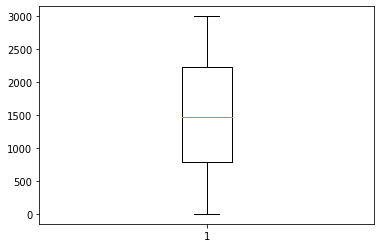

In [475]:
#6. Create a boxplot to check for outliers
plt.boxplot(new_df['visit'])

In [476]:
# outliers are 1.5IQR above the 3rd Quartile and 1.5IQR below the 1st quartile
new_df['visit'].describe()

count     974.000000
mean     1497.976386
std       838.959460
min         1.000000
25%       794.500000
50%      1477.000000
75%      2224.250000
max      2998.000000
Name: visit, dtype: float64

In [484]:
# the describe function shows that the first quartile is 794.5 and the third quartile is 2224.25. 
q1 = 794.5
q3 = 2224.25
iqr = q3-q1
upper = q3 + 1.5 * iqr
lower = q1 - 1.5 * iqr
print(upper, lower)

4368.875 -1350.125


In [483]:
#7. Get rid of any outliers
final_df = new_df[(new_df['visit'] <= upper) & (new_df['visit'] >= lower)]
final_df.shape

(974, 7)

It looks like the data is within the correct range of values and doesn't have outliers by default.

**3. Insert data into a SQL Lite database – create a table with the following data below that you will create yourself**

In [485]:
# import library
import sqlite3

In [500]:
# initializing database, setting cursor, and creating 10 unique rows
with sqlite3.connect("trial_table2.db") as conn:
    cursor = conn.cursor()
    cursor.execute("CREATE TABLE IF NOT EXISTS user2 (phone_number integer, first_name text, last_name text, address text, city text, state text, zip integer)")
    cursor.execute("INSERT INTO user2 VALUES ('1234444444', 'Bob', 'Codd', '10 Cool Drive', 'Fantasy City', 'AL', '12345')")
    cursor.execute("INSERT INTO user2 VALUES ('987654321', 'Rob', 'Dodd', '11 Bad Circle', 'Imagine City', 'GA', '87654')")
    cursor.execute("INSERT INTO user2 VALUES ('5555555555', 'Dod', 'Tob', '55 LOL Road', 'Google', 'NY', '55555')")
    cursor.execute("INSERT INTO user2 VALUES ('6969696969', 'Wob', 'Sob', '69 Funny Pass', 'Hehe', 'CA', '23465')")
    cursor.execute("INSERT INTO user2 VALUES ('1010010001', 'Yob', 'Pob', '1010 Binary Drive', 'Why', 'AZ', '10010')")
    cursor.execute("INSERT INTO user2 VALUES ('4561237890', 'Lob', 'Gob', '9 Whoops Way', 'Where', 'TX', '99999')")
    cursor.execute("INSERT INTO user2 VALUES ('8008008008', 'Bobo', 'Obob', '808 Oceanview Street', 'Boboland', 'NY', '55556')")
    cursor.execute("INSERT INTO user2 VALUES ('4088044080', 'Hob', 'Boh', '88 Homeless Pass', 'Hoboland', 'NY', '55557')")
    cursor.execute("INSERT INTO user2 VALUES ('7777777777', 'Lucky', 'Ducky', '777 Luck Street', 'Vegas', 'NV', '88901')")
    cursor.execute("INSERT INTO user2 VALUES ('6000000000', 'Prob', 'Lem', '99 Problems Road', 'Issues', 'HI', '60000')")
    cursor.execute("INSERT INTO user2 VALUES ('5103039042', 'Rabul', 'Rajeel', '42 Heritage Way', 'Mounlain Houle', 'CA', '95392')")
    conn.commit()

In [501]:
# querying for proof
with sqlite3.connect("trial_table2.db") as conn:
    cursor = conn.cursor()
    rows = cursor.execute('SELECT * from user2')
    for row in rows:
        print(row)

(1234444444, 'Bob', 'Codd', '10 Cool Drive', 'Fantasy City', 'AL', 12345)
(987654321, 'Rob', 'Dodd', '11 Bad Circle', 'Imagine City', 'GA', 87654)
(5555555555, 'Dod', 'Tob', '55 LOL Road', 'Google', 'NY', 55555)
(6969696969, 'Wob', 'Sob', '69 Funny Pass', 'Hehe', 'CA', 23465)
(1010010001, 'Yob', 'Pob', '1010 Binary Drive', 'Why', 'AZ', 10010)
(4561237890, 'Lob', 'Gob', '9 Whoops Way', 'Where', 'TX', 99999)
(8008008008, 'Bobo', 'Obob', '808 Oceanview Street', 'Boboland', 'NY', 55556)
(4088044080, 'Hob', 'Boh', '88 Homeless Pass', 'Hoboland', 'NY', 55557)
(7777777777, 'Lucky', 'Ducky', '777 Luck Street', 'Vegas', 'NV', 88901)
(6000000000, 'Prob', 'Lem', '99 Problems Road', 'Issues', 'HI', 60000)
(5103039042, 'Rabul', 'Rajeel', '42 Heritage Way', 'Mounlain Houle', 'CA', 95392)
